In [1]:
#!/usr/bin/env python

from __future__ import division, print_function

import sys
sys.path.insert(0, './gym-snake/')
import gym
import time
from optparse import OptionParser
import gym_snake
from gym_snake.envs.constants import GridType, Action4, Action6
from PyQt5.QtCore import Qt

from gym import wrappers
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
is_done = False


# Load the gym environment
env = gym.make('Snake-8x8-v0')
env.reset()
env.seed(99)
PATH = 'models/snakeai0.pkl'
model = torch.load(PATH)

register(
    id='Snake--4x4-DeadApple--v0',
    entry_point='gym_snake.envs:Snake__4x4_DeadApple_'
)
register(
    id='Snake-Hex-4x4-DeadApple--v0',
    entry_point='gym_snake.envs:Snake_Hex_4x4_DeadApple_'
)
register(
    id='Snake--8x8-DeadApple--v0',
    entry_point='gym_snake.envs:Snake__8x8_DeadApple_'
)
register(
    id='Snake-Hex-8x8-DeadApple--v0',
    entry_point='gym_snake.envs:Snake_Hex_8x8_DeadApple_'
)
register(
    id='Snake--16x16-DeadApple--v0',
    entry_point='gym_snake.envs:Snake__16x16_DeadApple_'
)
register(
    id='Snake-Hex-16x16-DeadApple--v0',
    entry_point='gym_snake.envs:Snake_Hex_16x16_DeadApple_'
)
register(
    id='Snake--4x4---v0',
    entry_point='gym_snake.envs:Snake__4x4__'
)
register(
    id='Snake-Hex-4x4---v0',
    entry_point='gym_snake.envs:Snake_Hex_4x4__'
)
register(
    id='Snake--8x8---v0',
    entry_point='gym_snake.envs:Snake__8x8__'
)
register(
    id='Snake-Hex-8x8---v0',
    entry_point='gym_snake.envs:Snake_Hex_8x8__'
)
register(
    

/home/malthet/anaconda3/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/home/malthet/anaconda3/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/home/malthet/anaconda3/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


In [6]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.BICUBIC),
                    T.ToTensor()])

def select_action(state):
    return model(state).max(1)[1].view(1, 1)

def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))

    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    
    # Resize, and add a batch dimension (BCHW)
    return resize(screen)#.unsqueeze(0)


/home/malthet/anaconda3/lib/python3.9/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [7]:

img = get_screen()


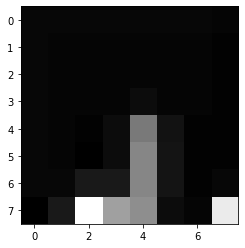

In [8]:
import matplotlib.pyplot as plt

plt.imshow(img.numpy()[0], cmap='gray')

In [5]:
# Create a window to render into
renderer = env.render('human')

def resetEnv():
    global is_done

    is_done = False
    env.reset()

resetEnv()

def keyDownCb(keyName):
    global is_done

    if keyName == Qt.Key_Escape:
        sys.exit(0)

    if keyName == Qt.Key_Backspace or is_done:
        resetEnv()
        return

    action = None
    if env.grid_type == GridType.square:
        if keyName == Qt.Key_Left or keyName == Qt.Key_A or keyName == Qt.Key_4:
            action = Action4.left
        elif keyName == Qt.Key_Right or keyName == Qt.Key_D or keyName == Qt.Key_6:
            action = Action4.right
        elif keyName == Qt.Key_Up or keyName == Qt.Key_Space or keyName == Qt.Key_Return or keyName == Qt.Key_W or keyName == Qt.Key_8:
            action = Action4.forward
        else:
            print("unknown key %s" % keyName)
            return

    elif env.grid_type == GridType.hex:
        if keyName == Qt.Key_Left or keyName == Qt.Key_Q or keyName == Qt.Key_7:
            action = Action6.left
        elif keyName == Qt.Key_Right or keyName == Qt.Key_E or keyName == Qt.Key_9:
            action = Action6.right
        elif keyName == Qt.Key_Up or keyName == Qt.Key_Space or keyName == Qt.Key_Return or keyName == Qt.Key_W or keyName == Qt.Key_8:
            action = Action6.forward
        elif keyName == Qt.Key_A or keyName == Qt.Key_4:
            action = Action6.left_left
        elif keyName == Qt.Key_D or keyName == Qt.Key_6:
            action = Action6.right_right

        else:
            print("unknown key %s" % keyName)
            return

    else:
        print('Unknown grid type: ', env.grid_type)

    if action is None:
        return

    obs, reward, done, info = env.step(action)

    print('step=%s, reward=%.2f' % (env.step_count, reward))

    if done:
        print('done!')
        is_done = True

renderer.window.setKeyDownCb(keyDownCb)

while True:
    env.render('human')
    time.sleep(0.01)

    # If the window was closed
    if renderer.window is None:
        break

unknown key 16777248
step=1, reward=0.00
unknown key 16777237
step=2, reward=0.00
step=3, reward=0.00
step=4, reward=0.00
step=5, reward=0.00
step=6, reward=0.00
step=7, reward=0.00
step=8, reward=0.00
step=9, reward=0.00
step=10, reward=0.00
step=11, reward=0.00
step=12, reward=1.00
step=13, reward=0.00
step=14, reward=0.00
step=15, reward=0.00
step=16, reward=0.00
step=17, reward=0.00
step=18, reward=1.00
step=19, reward=0.00
step=20, reward=0.00
step=21, reward=-1.00
done!
